In [1]:
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import linear_model, metrics, decomposition
import pprint
%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_data.csv', index_col='Respondent')
with open('column_mapping.json', 'r') as f:
    column_mapping = json.load(f)

In [3]:
row_drop_mask = ((df['YearsProgram'].isnull() & df['YearsCodedJob'].isnull()) |
                 (df['CareerSatisfaction'].isnull()) |
                 (df['JobSatisfaction'].isnull()) |
                 (df['YearsCodedJobPast'].notnull()))
rows_to_drop = df[row_drop_mask].index
df.drop(index=rows_to_drop, inplace=True)

In [4]:
cols_to_drop = []
for col in df.columns:
    if not col.startswith('Country_'):
        continue
    num_from_country = df[col].sum()
    if num_from_country < 10:
        cols_to_drop.append(col)

cols_to_drop += ['ExpectedSalary', 'StackOverflowSatisfaction', 'HoursPerWeek', 'YearsCodedJobPast']
df.drop(columns=cols_to_drop, inplace=True)

In [5]:
rows_with_no_YearsProgram = df[df['YearsProgram'].isnull()].index
df.loc[rows_with_no_YearsProgram, 'YearsProgram'] = df.loc[rows_with_no_YearsProgram, 'YearsCodedJob']
df.loc[df['YearsCodedJob'].isnull(), 'YearsCodedJob'] = 0

In [6]:
RegressionResult = namedtuple('RegressionResult', ['mse', 'coefficients'])

In [7]:
def regression(df, plot=True):
    train = df.sample(frac=0.9)
    train_without_salary = train.drop(columns='Salary')
    test = df.drop(train.index)
    test_without_salary = test.drop(columns='Salary')
    
    reg = linear_model.LinearRegression()
    reg.fit(train_without_salary, train['Salary'])
    coeffs = dict(zip(train_without_salary.columns, reg.coef_))
    
    predictions = reg.predict(test_without_salary)
    errors = predictions - test['Salary'].values
    if plot:
        plt.hist(errors, bins=20)
        plt.show()
    
    mse = metrics.mean_squared_error(test['Salary'], predictions)
    return RegressionResult(mse=mse, coefficients=coeffs)

In [8]:
blind_guess_train = df.sample(frac=0.9)
blind_guess_test = df.drop(blind_guess_train.index)
blind_guess_prediction = np.full(len(blind_guess_test), np.mean(blind_guess_train['Salary']))
mse_blind_guess = metrics.mean_squared_error(blind_guess_test['Salary'], blind_guess_prediction)
mse_blind_guess**0.5

39580.63360103157

In [9]:
def keep_columns(df, original_columns_to_keep):
    cleaned_columns_to_keep = []
    for original_col in original_columns_to_keep:
        cleaned_columns = column_mapping[original_col]
        for cleaned_col in cleaned_columns:
            if cleaned_col not in cols_to_drop:
                cleaned_columns_to_keep.append(cleaned_col) 
    return df[cleaned_columns_to_keep + ['Salary']].dropna()

In [10]:
results_by_col = {}
for original_column in column_mapping:
    if original_column == 'Salary' or original_column in cols_to_drop:
        continue
    result = regression(keep_columns(df, [original_column]), plot=False)
    results_by_col[original_column] = result

In [11]:
most_correlated_inputs = sorted(results_by_col.keys(), key=lambda c: results_by_col[c].mse)

In [12]:
for input_var in most_correlated_inputs:
    print('{}: {}'.format(input_var, results_by_col[input_var].mse**0.5))

Country: 26232.35774951588
Currency: 31659.988142902508
YearsCodedJob: 35169.94650655606
YearsProgram: 35279.73211920148
ImportantBenefits: 37243.199474134555
DiversityImportant: 37549.39876220126
SelfTaughtTypes: 37576.310505149515
University: 37717.412345763936
StackOverflowAdsDistracting: 37809.042883101356
JobProfile: 37900.70514965492
StackOverflowCommunity: 38013.29068517621
Race: 38080.66649144745
HaveWorkedLanguage: 38091.02520788
StackOverflowDescribes: 38187.23741053132
ImportantHiringCompanies: 38216.474420934916
CompanySize: 38300.185496978
StackOverflowCopiedCode: 38315.944321404124
HighestEducationParents: 38504.264106524846
HomeRemote: 38539.69773456453
LastNewJob: 38544.89361076395
ProgramHobby: 38564.258160036086
InfluenceCommunication: 38572.74462299206
Overpaid: 38577.906393210025
AssessJobDiversity: 38585.012348395634
ImportantHiringTechExp: 38594.93774638032
CompanyType: 38615.62442589174
BuildingThings: 38627.56966690169
StackOverflowJobListing: 38641.669441663194

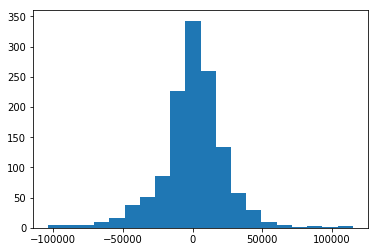

23325.48654906205

In [13]:
predictors = ['Country', 'Currency', 'YearsCodedJob']
res1 = regression(keep_columns(df, predictors))
res1.mse**0.5

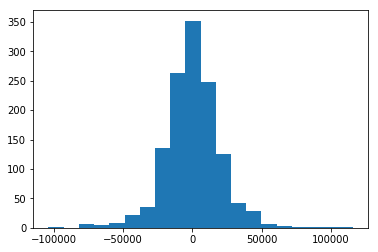

20139.084730696053


{'.NET Core': 524373797721.5781,
 'Agile': 1079.62890625,
 'Amazon Web Services (AWS)': 2358445867796.664,
 'Android': -52405900492404.93,
 'Android Studio': -387.24609375,
 'Android app': -526.32763671875,
 'Android browser': -539.41796875,
 'AngularJS': -115475540566.76367,
 'AnnoyingUI_Agree': -2816.1519775390625,
 'AnnoyingUI_Disagree': -1360.6083984375,
 'AnnoyingUI_Somewhat agree': -2861.7216796875,
 'AnnoyingUI_Strongly agree': -3046.5419921875,
 'AnnoyingUI_Strongly disagree': -5583.5926513671875,
 'Annual bonus': 2346.1982421875,
 'Arduino': 276639148674.8711,
 'Assembly': -1634857305909.735,
 'AssessJobCommute_Important': -12190.568359375,
 'AssessJobCommute_Not at all important': -16399.552947998047,
 'AssessJobCommute_Not very important': -11611.968994140625,
 'AssessJobCommute_Somewhat important': -13218.9814453125,
 'AssessJobCommute_Very important': -11953.7021484375,
 'AssessJobCompensation_Important': -876.822265625,
 'AssessJobCompensation_Not at all important': -1487

In [14]:
all_predictor_cols = [col for col in column_mapping.keys() if col != 'Salary']
res1 = regression(keep_columns(df, all_predictor_cols))
print(res1.mse**0.5)
res1.coefficients

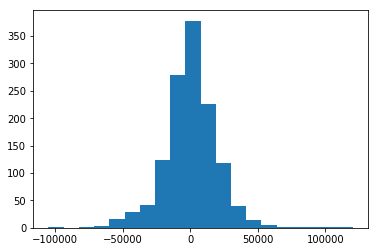

19927.9109943891

In [15]:
PCA = decomposition.PCA()
df_without_salary = df.drop(columns='Salary') 
PCA.fit(df_without_salary)
pca_ndarray = PCA.transform(df_without_salary)
pca_cols = ['PC{}'.format(i) for i in range(len(df_without_salary.columns))]
pca_df = pd.DataFrame(pca_ndarray, index=df.index, columns=pca_cols)
pca_df['Salary'] = df['Salary']
pca_reg = regression(pca_df)
pca_reg.mse**0.5

In [16]:
results_by_pc = {}
for principal_component in pca_df.drop(columns='Salary').columns:
    result = regression(pca_df[[principal_component, 'Salary']], plot=False)
    results_by_pc[principal_component] = result

In [17]:
most_correlated_pcs = sorted(results_by_pc.keys(), key=lambda pc: results_by_pc[pc].mse)

In [18]:
for principal_component in most_correlated_pcs:
    print('{}: {}'.format(principal_component, results_by_pc[principal_component].mse**0.5))

PC0: 34601.32851773209
PC928: 37454.29099829184
PC73: 37568.21884579056
PC277: 37767.65332686918
PC167: 37805.672493536156
PC689: 37852.72216623496
PC882: 37859.29269554397
PC11: 37909.28104001451
PC972: 37915.70519001222
PC778: 38025.43209884658
PC625: 38031.400584030336
PC475: 38050.198247133856
PC14: 38120.665499135175
PC968: 38130.91010072581
PC139: 38170.0308485541
PC519: 38188.93025098533
PC948: 38195.16812205383
PC959: 38197.23607961809
PC679: 38201.12682800941
PC427: 38202.20785927618
PC805: 38244.84174119021
PC166: 38314.964014344645
PC742: 38315.72027547729
PC579: 38337.01638191055
PC621: 38346.35356098987
PC627: 38358.734494201184
PC642: 38372.974032735765
PC734: 38374.569221807
PC906: 38378.129948129885
PC335: 38382.53468450973
PC977: 38392.85862945616
PC228: 38396.50820312553
PC415: 38397.97007560546
PC872: 38399.782084506274
PC209: 38422.86609303265
PC246: 38423.25448505655
PC969: 38429.80443735111
PC588: 38432.683147367636
PC633: 38439.75700344695
PC869: 38441.6976675566

In [ ]:
npcs = list(range(1, 984, 10))
pca_mses = []
for npc in npcs:
    cols = most_correlated_pcs[:npc] + ['Salary']
    result = regression(pca_df[cols], plot=False)
    pca_mses.append(result.mse**0.5)
    if ((npc - 1) % 100 == 0): print(npc)

1
101
201
301
401
501
601
701


In [ ]:
cols = most_correlated_pcs + ['Salary']
result = regression(pca_df[cols], plot=False)

In [ ]:
result.mse**0.5

In [ ]:
plt.plot(npcs, pca_mses)

In [ ]:
# pca_reg_results = pd.DataFrame({'NumPrincipalComponents':npcs, 'Mse':pca_mses}).set_index('NumPrincipalComponents')
# pca_reg_results.to_csv('pca_reg_results.csv')

In [ ]:
# regression(pca_df, plot=False).mse**0.5